# Physics check

In this notebook we check that the algorithm actually yields the correct results. The neat thing about the Ising model in 2D is that we do have an [analytical solution](https://en.wikipedia.org/wiki/Square_lattice_Ising_model) which was found by Lars Onsager in 1944.


We know the actual theoretical values for magnetization at $J=1, \: h=0$ as a function of temperature

$$
    m = [1-\sinh^{-4}(2\beta)]^{1/8}
$$

The average energy per spin site is

$$
    E = -\coth(2\beta)\left[1 + \dfrac{2}{\pi}(2\tanh^2(2\beta)-1)\int_0^{\pi/2} \dfrac{1}{\sqrt{1-4k(1+k)^{-2}\sin^2\theta}}\right]
$$

The model is characterized by a phase transition, where the spins pass from being mostly *ordered* in alignment for $T<T_c$ to being randomly aligned for $T>T_c$ (*disordered*). This is tied to a divergence in the range of  correlations between spin sites and thus to the size of the average cluster of aligned spins. The analytical value of the critical temperature is such that
$$
k_BT_c/J = 2/\ln(1+\sqrt 2)\approx 2.269
$$

In [ ]:
import numpy as np
import pandas as pd
import plot_formatting as pf #Custom for LaTeX grade plots
import os
import glob
import re
import matplotlib.pyplot as plt

datapath = '../data/'

def grab_ising_chain(folder_path, otype='magnetization'):
    """
    Find the all the .csv files containing the markov chains at a given temperature
    """
    pattern = os.path.join(folder_path, f'ising_T*_N512_{otype}.csv')
    re_pattern = rf'ising_T([\d.]+)_N512_{otype}\.csv'
    file_paths = glob.glob(pattern)
    results = []
    for file_path in file_paths:
        match = re.search(re_pattern, os.path.basename(file_path))
        if match:
            temperature = float(match.group(1))
            results.append((temperature, file_path))
    return results

def get_mean(res_tuple, otype='magnetization', cutoff=2500):
    """
    Calculate the average of a given observable Markov chain
    """
    df = pd.read_csv(res_tuple[1])
    m = df[otype].to_numpy()
    T = res_tuple[0]
    return T, m[cutoff:].mean()

def onsager_m(T):
    """
    Analytical values of the magnetization at J=1 and h=0
    """
    Tc = 2/np.log(1+np.sqrt(2))
    m = np.zeros_like(T)
    m[T < Tc] = np.power(1-np.power(np.sinh(2/T[T < Tc]), -4), 1/8)
    return m

def ellipk(M):
    """Complete elliptic integral of the first kind"""
    res = []
    for m in M:
        # K(m) = ∫[0 to π/2] dθ / √(1 - m*sin²(θ))
        theta = np.linspace(0, np.pi/2, 10000)
        theta = theta[1:-1]
        integrand = 1 / np.sqrt(1 - m * np.sin(theta)**2)
        res.append(np.trapz(integrand, theta))
    return np.array(res)

def onsager_e(T):
    """
    Analytical values of the energy at J=1 and h=0
    """
    Tc = 2/np.log(1+np.sqrt(2))
    k = np.power(np.sinh(2/T), -2)
    K = ellipk(4*k/(1+k)**2)
    return -(1+2/np.pi*K*(2*np.tanh(2/T)**2-1))/np.tanh(2/T)

def get_obs(datapath, otype='magnetization'):
    res = grab_ising_chain(datapath, otype)
    temps = np.zeros(len(res))
    obs = np.zeros(len(res))
    for i, r in enumerate(res):
        t, o = get_mean(r, otype)
        temps[i]= t 
        obs[i] = o
    idx = np.argsort(temps)
    temps.sort()
    obs = obs[idx]
    return temps, obs

In [31]:
N = 512
t_cont = np.linspace(0.5, 3, 200)
m_ons = onsager_m(t_cont)
e_ons = onsager_e(t_cont)
temps, mag = get_obs(datapath)

/tmp/ipykernel_5986/184618450.py:27: RuntimeWarning: Mean of empty slice.
  return T, m[cutoff:].mean()
/home/jetson/miniforge3/envs/mcp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


# 1. Magnetization plot

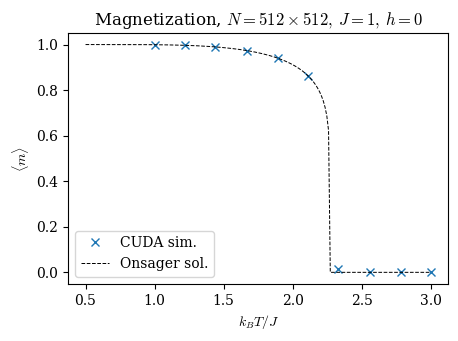

In [40]:
size, line = pf.plot_formatting(0.7, 4/3)
fig, ax = plt.subplots(figsize = size)
ax.set_xlabel(r'$k_BT/J$')
ax.set_ylabel(r'$\langle m\rangle$')
ax.set_title(fr'Magnetization, $N={N}\times{N},\: J=1,\:h=0$')
ax.plot(temps, mag, 'x', label='CUDA sim.')
ax.plot(t_cont, m_ons, '--', color='black', lw=line/2, label='Onsager sol.') #Onsager
ax.legend()
plt.tight_layout()
fig.savefig('magnetization.svg')
plt.show()

## 1.2 Energy

/tmp/ipykernel_5986/184618450.py:27: RuntimeWarning: Mean of empty slice.
  return T, m[cutoff:].mean()
/home/jetson/miniforge3/envs/mcp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


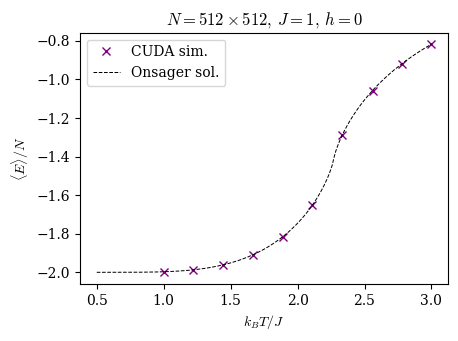

In [38]:
temps, en = get_obs(datapath, otype='energy')
size, line = pf.plot_formatting(0.7, 4/3)
fig, ax = plt.subplots(figsize = size)
ax.set_xlabel(r'$k_BT/J$')
ax.set_ylabel(r'$\langle E\rangle/N$')
ax.set_title(fr'$N={N}\times{N},\: J=1,\:h=0$')
ax.plot(temps, en/N**2, 'x', color='purple', label='CUDA sim.')
ax.plot(t_cont, e_ons, '--', color='black', lw=line/2, label='Onsager sol.') #Onsager
ax.legend()
plt.tight_layout()
fig.savefig('energy.svg')
plt.show()

# 2. Spin evolution plot

We see here a typical spin state in the disordered phase ($T<T_c$) and one in the ordered phase but close to criticality ($T \gtrsim T_c$). Both start from a positive magnetization state, after the chain converges we see the difference in cluster size

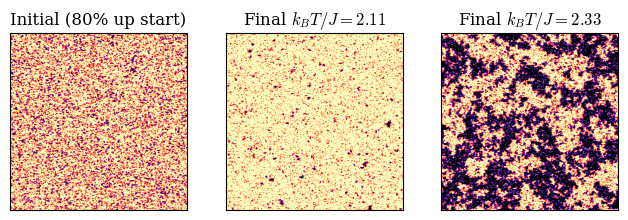

In [ ]:
init = '../data/ising_T2.11_N512_state_000000.bin'
final_ordered = '../data/ising_T2.11_N512_state_009900.bin'
final_disordered = '../data/ising_T2.33_N512_state_009900.bin'

import struct

def load_binary(filename):
    """
    Black and white MCMC spin states are saved as binary files. The header contains the number 
    of rows and columns. 
    """
    with open(filename, 'rb') as f:
        nrow = struct.unpack('i', f.read(4))[0]
        ncol = struct.unpack('i', f.read(4))[0]
        n_elements = nrow * ncol // 2
        black_spins = np.frombuffer(f.read(n_elements), dtype=np.int8)
        white_spins = np.frombuffer(f.read(n_elements), dtype=np.int8)
    return black_spins, white_spins, nrow, ncol

def reconstruct_bw(black_spins, white_spins, nrow, ncol):
    """
    Given arrays of black and white spins reconstruct the full lattice matrix
    """
    full_lattice = np.zeros((nrow, ncol), dtype=np.int8)
    black_idx = 0
    white_idx = 0
    for i in range(nrow):
        for j in range(ncol):
            if (i + j) % 2 == 0:
                full_lattice[i, j] = white_spins[white_idx]
                white_idx += 1
            else:
                full_lattice[i, j] = black_spins[black_idx]
                black_idx += 1
    
    return full_lattice

def get_lattice(filename):
    black_spins, white_spins, nrow, ncol = load_binary(filename)
    full_lattice = reconstruct_bw(black_spins, white_spins, nrow, ncol)
    return full_lattice

in_lattice = get_lattice(init)
fo_lattice = get_lattice(final_ordered)
fd_lattice = get_lattice(final_disordered)
size, line = pf.plot_formatting(0.33, 1)
fig, ax = plt.subplots(1, 3, figsize = (3*size[0], size[1]))
ax[0].set_title('Initial (80% up start)')
ax[0].imshow(in_lattice, cmap='magma')
ax[1].set_title(r'Final $k_BT/J = 2.11$')
ax[1].imshow(fo_lattice, cmap='magma')
ax[2].set_title(r'Final $k_BT/J = 2.33$')
ax[2].imshow(fd_lattice, cmap='magma')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
fig.savefig('spin.png')
plt.show()